 Number of Observations: 352
 Number of Variables: 82

📊 Frequency Table — Treatment vs Gender
Treatment  Don't Know  No  Possibly  Yes
Gender                                  
female              2  16        14   46
male               16  65        46   69


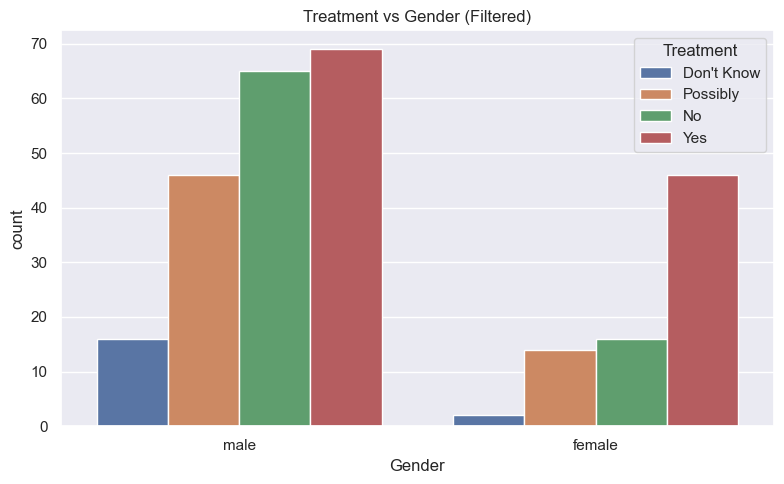


vFrequency Table — Treatment vs Age Group
Treatment  Don't Know  No  Possibly  Yes
AgeGroup                                
<25                 7   7         8   16
25-35              14  44        34   58
35-50               5  45        25   65
50+                 0   7         8    8


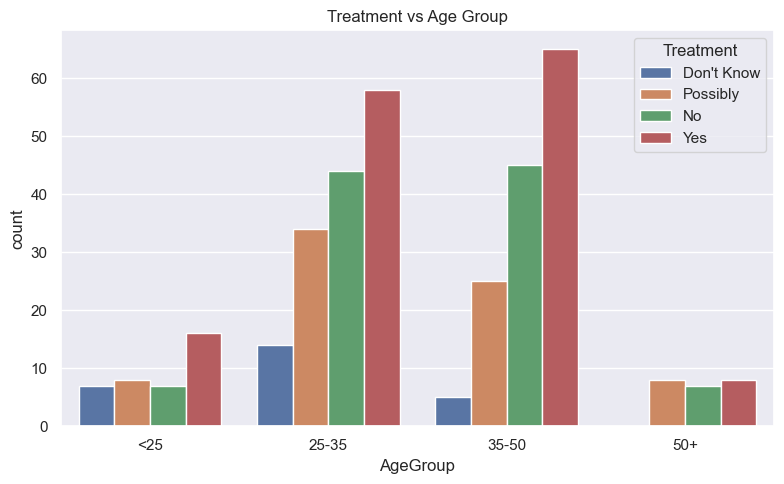


 Frequency Table — Treatment vs Race
Treatment                   Don't Know  No  Possibly  Yes
Race                                                     
Asian                                1   6         1    1
Black or African American            0   0         0    4
Caucasian                            0   0         0    1
European American                    0   1         0    0
Hispanic                             0   1         0    0
I prefer not to answer               0   0         2    4
More than one of the above           0   3         1    4
White                                9  39        32   93
White Hispanic                       0   0         1    0
nan                                 16  54        38   40


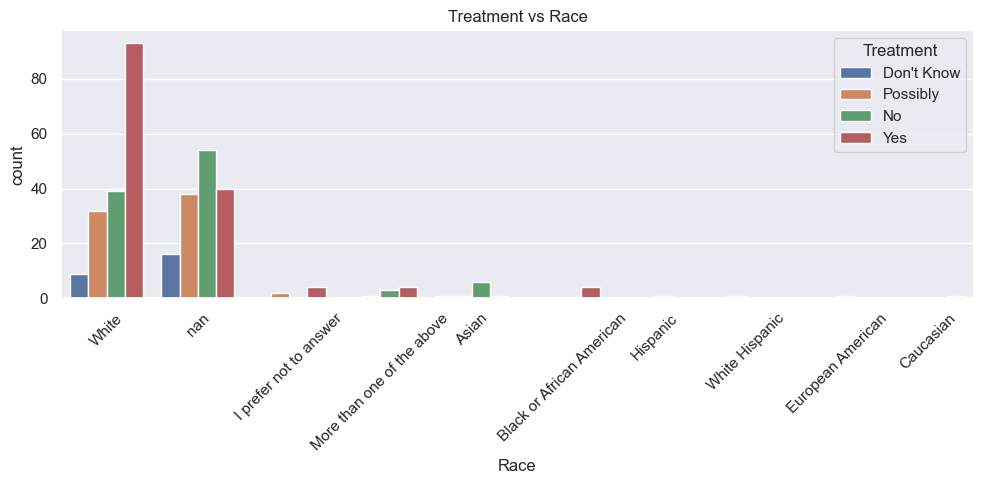

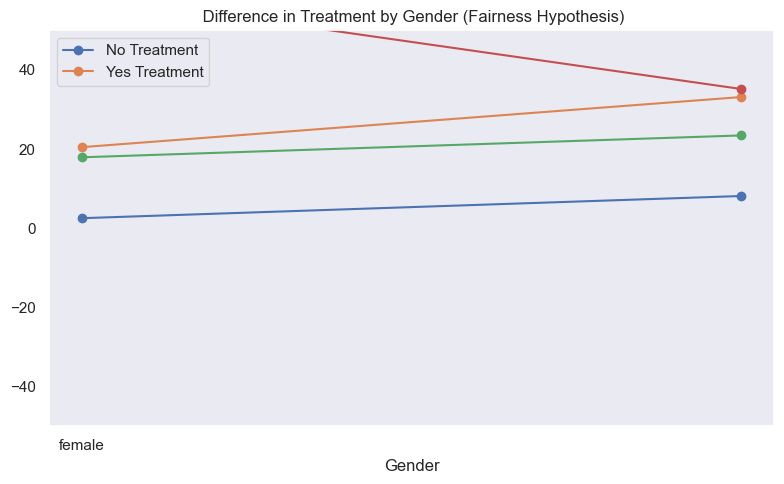

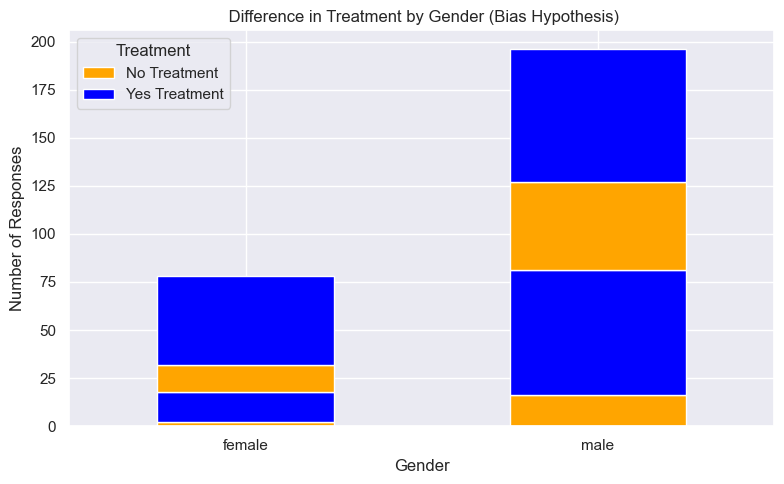

In [45]:

# ============================
# STEP 1: Import & Clean Data
# ============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/Users/reubenharuray/Downloads/mental-health-in-tech-survey-2019.csv")

# Clean column names
df.columns = df.columns.str.replace("*", "", regex=False).str.strip()

# Clean all string fields
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.replace("*", "", regex=False).str.strip()

# ============================
# STEP 2: Dataset Summary
# ============================
num_rows, num_cols = df.shape
print(f" Number of Observations: {num_rows}")
print(f" Number of Variables: {num_cols}")

# ============================
# STEP 3: Protected Class Analysis
# ============================

# Select and rename needed columns
selected_df = df[[
    'What is your gender?',
    'What is your age?',
    'What is your race?',
    'Do you currently have a mental health disorder?'
]].dropna()

selected_df.rename(columns={
    'What is your gender?': 'Gender',
    'What is your age?': 'Age',
    'What is your race?': 'Race',
    'Do you currently have a mental health disorder?': 'Treatment'
}, inplace=True)

# Clean Age and categorize
selected_df['Age'] = pd.to_numeric(selected_df['Age'], errors='coerce')
selected_df = selected_df.dropna(subset=['Age'])
selected_df['AgeGroup'] = pd.cut(selected_df['Age'], bins=[0, 25, 35, 50, 100], labels=["<25", "25-35", "35-50", "50+"])

# Clean Gender & filter to male/female
selected_df['Gender'] = selected_df['Gender'].str.lower().str.strip()
gender_filtered = selected_df[selected_df['Gender'].isin(['male', 'female'])]

# ============================
# STEP 3a: Frequency Table & Plot - Gender
# ============================
print("\n Frequency Table — Treatment vs Gender")
print(pd.crosstab(gender_filtered['Gender'], gender_filtered['Treatment']))

plt.figure(figsize=(8, 5))
sns.countplot(data=gender_filtered, x='Gender', hue='Treatment')
plt.title("Treatment vs Gender (Filtered)")
plt.tight_layout()
plt.show()

# ============================
# STEP 3b: Frequency Table & Plot - Age Group
# ============================
print("\nvFrequency Table — Treatment vs Age Group")
print(pd.crosstab(selected_df['AgeGroup'], selected_df['Treatment']))

plt.figure(figsize=(8, 5))
sns.countplot(data=selected_df, x='AgeGroup', hue='Treatment')
plt.title("Treatment vs Age Group")
plt.tight_layout()
plt.show()

# ============================
# STEP 3c: Frequency Table & Plot - Race
# ============================
print("\n Frequency Table — Treatment vs Race")
print(pd.crosstab(selected_df['Race'], selected_df['Treatment']))

plt.figure(figsize=(10, 5))
sns.countplot(data=selected_df, x='Race', hue='Treatment')
plt.title("Treatment vs Race")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================
# STEP 4: Visual Manipulation (Fairness vs. Bias)
# ============================

# FAIRNESS HYPOTHESIS GRAPH
plt.figure(figsize=(8, 5))
fair_data = gender_filtered.groupby('Gender')['Treatment'].value_counts(normalize=True).unstack().fillna(0) * 100
fair_data.plot(kind='line', marker='o', ylim=(-50, 50), ax=plt.gca())

plt.title(" Difference in Treatment by Gender (Fairness Hypothesis)")
plt.ylabel("")  # Hide Y label
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.grid(False)
plt.legend(["No Treatment", "Yes Treatment"])
plt.tight_layout()
plt.show()

# 📌 Description:
# Line plot with flat scale (-50 to 50), no y-axis label, hides real variation

# BIAS HYPOTHESIS GRAPH
plt.figure(figsize=(8, 5))
bias_data = gender_filtered.groupby('Treatment')['Gender'].value_counts().unstack().fillna(0)
bias_data.T.plot(kind='bar', stacked=True, color=["orange", "blue"], ax=plt.gca())

plt.title(" Difference in Treatment by Gender (Bias Hypothesis)")
plt.ylabel("Number of Responses")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.legend(["No Treatment", "Yes Treatment"], title="Treatment")
plt.tight_layout()
plt.show()

# 📌 Description:
# Stacked bar chart, tight Y-axis, color-coded to highlight difference


📊 Gender (Protected Class) Statistics
                               Mean            Median          Mode           
Original Dataset               0 (Male) (0.28)   0 (Male)   0 (Male)
Reduced Dataset (50%)          0 (Male) (0.26)   0 (Male)   0 (Male)
Difference                     Difference      No Difference   No Difference  

 Frequency Table — Treatment vs Gender (Reduced Dataset)
Treatment  Don't Know  No  Possibly  Yes
Gender                                  
female              2  10         3   21
male                7  33        26   35


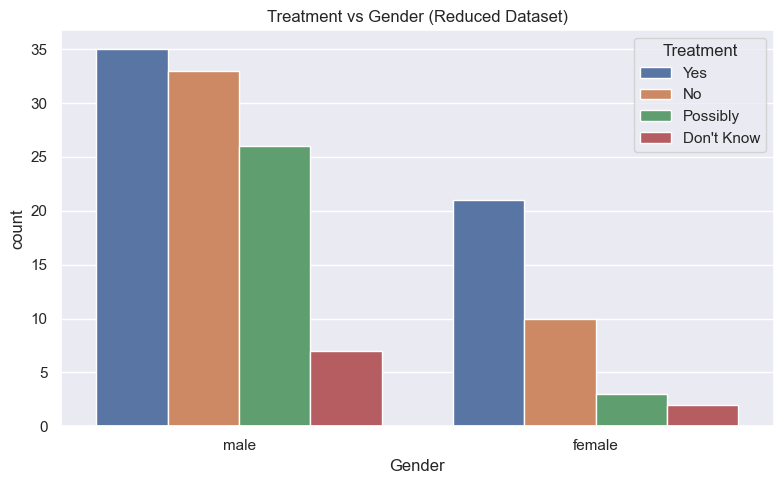

In [52]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean
df = pd.read_csv("/Users/reubenharuray/Downloads/mental-health-in-tech-survey-2019.csv")
df.columns = df.columns.str.replace("*", "", regex=False).str.strip()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.replace("*", "", regex=False).str.strip()

# Select Gender and Treatment
df_clean = df[['What is your gender?', 'Do you currently have a mental health disorder?']].dropna()
df_clean.rename(columns={
    'What is your gender?': 'Gender',
    'Do you currently have a mental health disorder?': 'Treatment'
}, inplace=True)

# Normalize gender and filter only male/female
df_clean['Gender'] = df_clean['Gender'].str.lower().str.strip()
df_clean = df_clean[df_clean['Gender'].isin(['male', 'female'])]

# Map gender to binary for analysis
df_clean['GenderBinary'] = df_clean['Gender'].map({'male': 0, 'female': 1})

# STEP 5: Descriptive statistics
mean_orig = df_clean['GenderBinary'].mean()
median_orig = df_clean['GenderBinary'].median()
mode_orig = df_clean['GenderBinary'].mode().iloc[0]

# 50% random sample
df_sample = df_clean.sample(frac=0.5, random_state=42)

mean_sample = df_sample['GenderBinary'].mean()
median_sample = df_sample['GenderBinary'].median()
mode_sample = df_sample['GenderBinary'].mode().iloc[0]

# Print results
def interpret(val): return "1 (Female)" if val == 1 else "0 (Male)"

print("\n📊 Gender (Protected Class) Statistics")
print(f"{'':<30} {'Mean':<15} {'Median':<15} {'Mode':<15}")
print(f"{'Original Dataset':<30} {interpret(mean_orig)} ({mean_orig:.2f})   {interpret(median_orig)}   {interpret(mode_orig)}")
print(f"{'Reduced Dataset (50%)':<30} {interpret(mean_sample)} ({mean_sample:.2f})   {interpret(median_sample)}   {interpret(mode_sample)}")

# Differences
diff_mean = "Difference" if mean_orig != mean_sample else "No Difference"
diff_median = "Difference" if median_orig != median_sample else "No Difference"
diff_mode = "Difference" if mode_orig != mode_sample else "No Difference"
print(f"{'Difference':<30} {diff_mean:<15} {diff_median:<15} {diff_mode:<15}")

# STEP 6: Frequency Table
print("\n Frequency Table — Treatment vs Gender (Reduced Dataset)")
print(pd.crosstab(df_sample['Gender'], df_sample['Treatment']))

# STEP 6: Histogram
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sample, x='Gender', hue='Treatment', order=['male', 'female'])
plt.title("Treatment vs Gender (Reduced Dataset)")
plt.tight_layout()
plt.show()